In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
import utils as u
u.check_python_version()
u.check_virtual_memory()

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Virtual memory usage - total: 31 GB / available: 25 GB / percent used: 17.4 %


In [4]:
# Open a dataset with monthly data
ds = xr.open_dataset(
#     '/home/msantola/TP_CLiMAF/ReferenceSNOW/SNC/SNCRefData/snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc'
    'snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc'
)
ds

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, nbnds: 2, time: 1968)
Coordinates:
  * lat        (lat) float32 88.542 86.6531 84.7532 ... -86.6531 -88.542
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 354.375 356.25 358.125
  * time       (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    snowc      (time, lat, lon) float32 ...
Attributes:
    Conventions:             CF-1.2
    title:                   4x Daily NOAA-CIRES 20th Century Reanalysis V2c
    platform:                Model
    institution:             NOAA ESRL Physical Sciences Division & CU/CIRES ...
    citation:                Compo,G.P. <http://www.esrl.noaa.gov/psd/people/...
    version:                 2c
    contact:                 esrl.psd.data@noaa.gov
    source:                  20CRv2c 2014, Ensemble Kalman Filter, ocean (spe...
    forcing_note:            Additional information on the exte

In [5]:
# Get the variable and perdiod
da = ds.snowc.sel(time=slice('1984', '2014'))
da

<xarray.DataArray 'snowc' (time: 372, lat: 94, lon: 192)>
[6713856 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


## Make month weights
http://xarray.pydata.org/en/stable/examples/monthly-means.html  
(bug leap year fixed: https://github.com/pydata/xarray/pull/3464)

In [6]:
# Days per month for different calendar types
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [7]:
# Deal with leap years
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar) and month == 2:
            month_length[i] += 1
    return month_length

In [8]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(da.time.to_index(), calendar='gregorian'),
                            coords=[da.time], name='month_length')
month_length

<xarray.DataArray 'month_length' (time: 372)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,

In [9]:
# Check leap year
import calendar

year = 2000

print(calendar.isleap(year))
month_length.sel(time=str(year))

True


<xarray.DataArray 'month_length' (time: 12)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01

## Season climatology

### Compute the weights

In [10]:
# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length / month_length.astype(float).sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.sum().values, np.ones(1))

In [11]:
# Check weights
weights.head(10)

<xarray.DataArray 'month_length' (time: 10)>
array([0.00273779, 0.00256116, 0.00273779, 0.00264947, 0.00273779,
       0.00264947, 0.00273779, 0.00273779, 0.00264947, 0.00273779])
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 1984-10-01

In [12]:
month_length.head(10)

<xarray.DataArray 'month_length' (time: 10)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 1984-10-01

### Compute the climatology

In [13]:
# Calculate the weighted average
clim_weighted = (da * weights).sum(dim='time', skipna=False)
clim_not_weighted = da.mean(dim='time', skipna=False)

In [14]:
clim_weighted

<xarray.DataArray (lat: 94, lon: 192)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125

### Plot the results

<IPython.core.display.Javascript object>


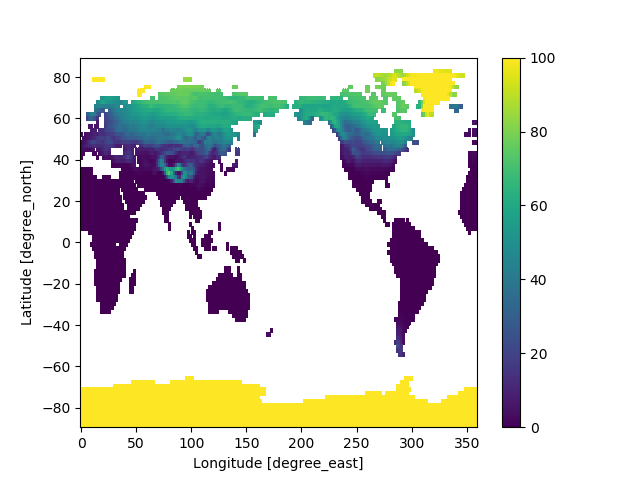

In [15]:
plt.figure()
clim_weighted.plot()

<IPython.core.display.Javascript object>


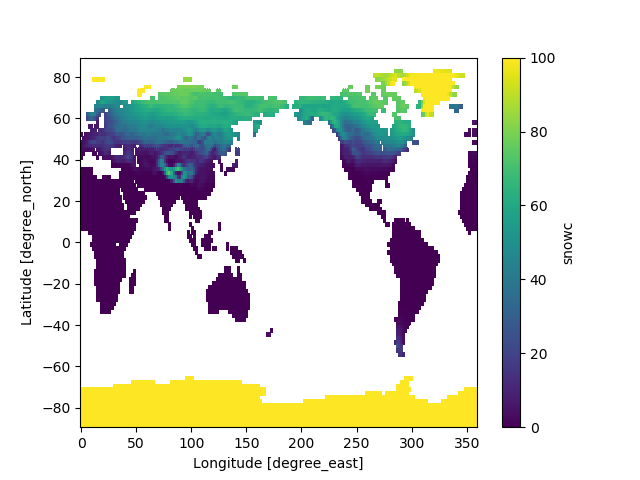

In [14]:
plt.figure()
clim_not_weighted.plot()

<IPython.core.display.Javascript object>


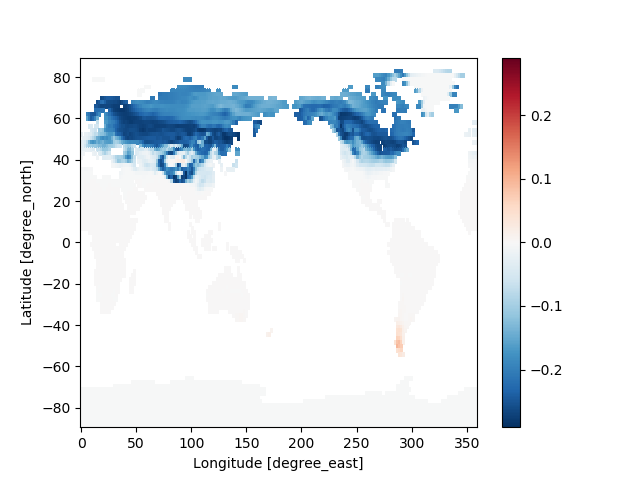

In [16]:
plt.figure()
(clim_weighted-clim_not_weighted).plot()

## With utils.clim function

In [17]:
clim = u.clim(da, calendar='gregorian')
clim

<xarray.DataArray (lat: 94, lon: 192)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125

<IPython.core.display.Javascript object>


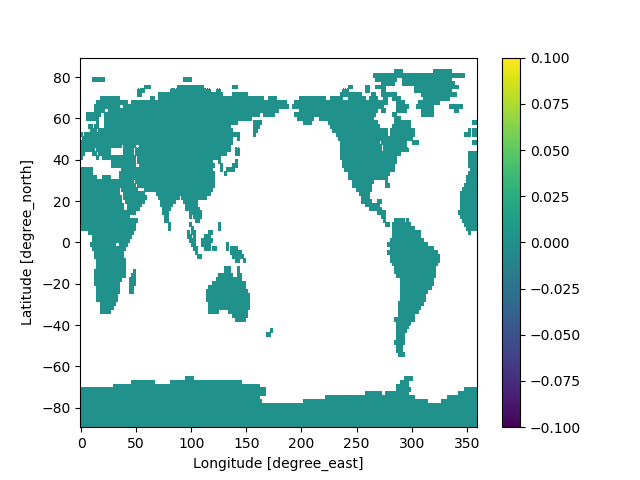

In [18]:
# Check that it is the same
plt.figure()
(clim_weighted-clim).plot()

# Check for yearly data

In [19]:
year_mean = u.year_mean(da)
year_mean

<xarray.DataArray (year: 31, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100

<IPython.core.display.Javascript object>


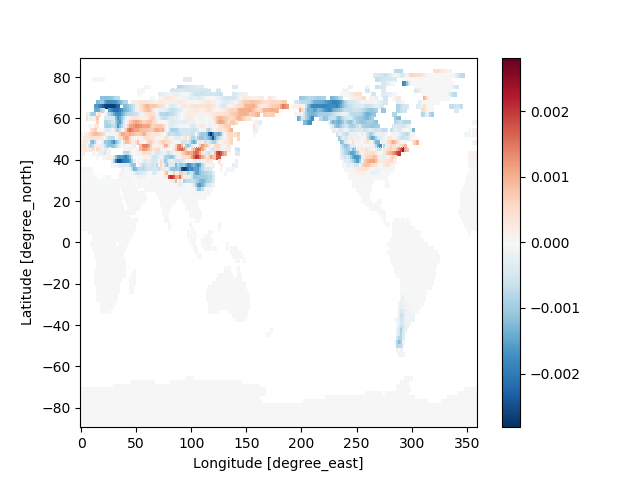

/home/lalandmi/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
plt.figure()
(year_mean.mean('year')-clim).plot()

In [22]:
year_mean['year']

<xarray.DataArray 'year' (year: 31)>
array([1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014])
Coordinates:
  * year     (year) int64 1984 1985 1986 1987 1988 ... 2010 2011 2012 2013 2014

In [24]:
xr.DataArray(get_dpm(ds.time.to_index(), calendar='gregorian'),
                                coords=[ds.time], name='month_length')

<xarray.DataArray 'month_length' (time: 1968)>
array([31, 28, 31, ..., 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01

In [25]:
import calendar
year_lenght = xr.DataArray(
    [366 if calendar.isleap(i) else 365 for i in year_mean['year'].values],
    coords=[year_mean.year], name='year_lenght'
)
year_lenght

<xarray.DataArray 'year_lenght' (year: 31)>
array([366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366,
       365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365,
       365, 365, 366, 365, 365])
Coordinates:
  * year     (year) int64 1984 1985 1986 1987 1988 ... 2010 2011 2012 2013 2014

In [26]:
weights = year_lenght / year_lenght.sum()
test = (year_mean * weights).sum('year')

<IPython.core.display.Javascript object>


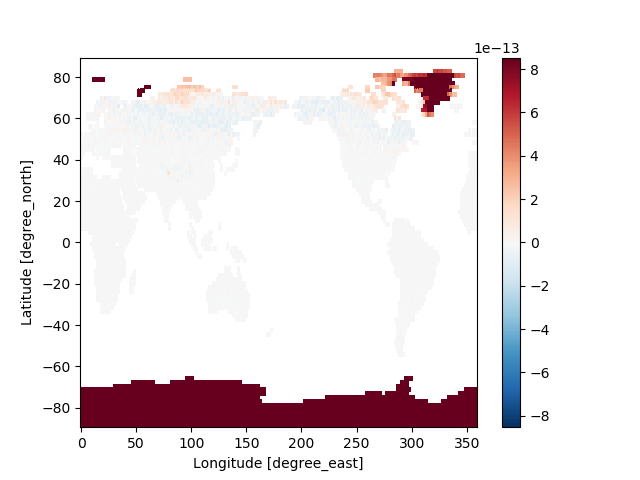

In [27]:
plt.figure()
(test-clim).plot()

# Check with CDO

In [2]:
!cdo timmean snowc.ymonavg.noaaV2c_198401_201412_2.0x1.75.nc snowc.timmean.noaaV2c_198401_201412_2.0x1.75.nc

Warning (cdfDefVar): Changed double entry of variable name 'time_bnds' to 'time_bnds_2'!
cdo timmean: Processed 216600 values from 2 variables over 12 timesteps [0.01s 53MB]


In [28]:
clim_cdo = xr.open_dataset('snowc.timmean.noaaV2c_198401_201412_2.0x1.75.nc').snowc
clim_cdo

<xarray.DataArray 'snowc' (time: 1, lat: 94, lon: 192)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2014-06-16
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
Attributes:
    long_name:         Monthly Snow Cover at Surface
    units:             %
    cell_methods:      time: mean (monthly from 3-hourly values)
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    statistic_method:  Ensemble mean is calculated by ave

<IPython.core.display.Javascript object>


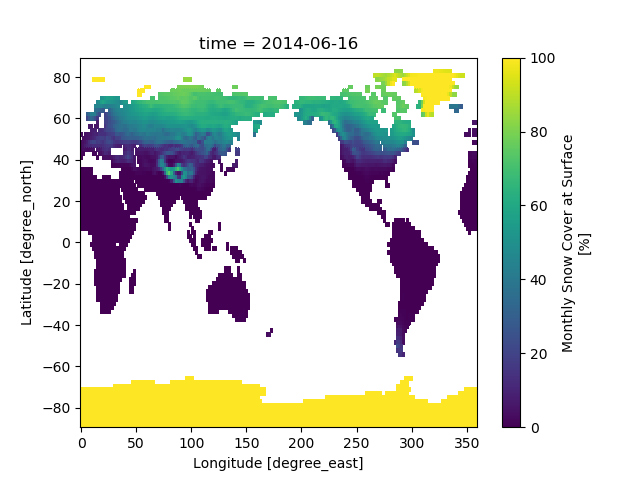

In [29]:
plt.figure()
clim_cdo[0].plot()

<IPython.core.display.Javascript object>


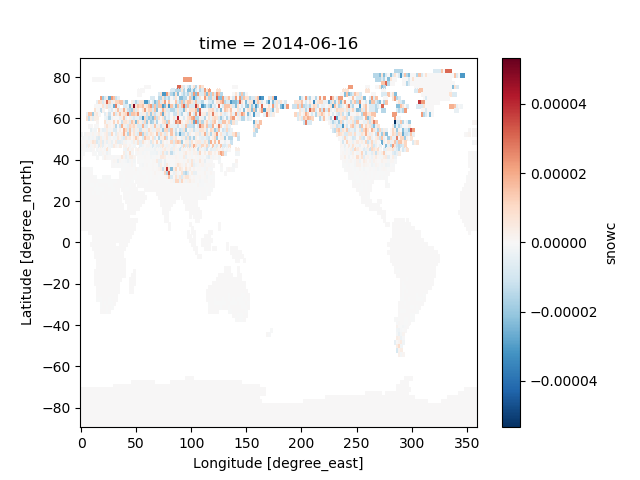

In [30]:
plt.figure()
(clim_cdo[0]-clim_not_weighted).plot()